In [1]:
import numpy as np
import os
import scipy.io as sio
import matplotlib.pyplot as plt

In [2]:
matlab_file_path = '../../matlab_files/PoissionEditing-master/MixingGradients/'

In [3]:
variables = sio.loadmat(os.path.join(matlab_file_path, 'variables.mat'))

In [4]:
background1 = variables['b1']
background2 = variables['b2']
background3 = variables['b3']

In [5]:
object_source1 = variables['object_source1']
object_source2 = variables['object_source2']
object_source3 = variables['object_source3']

In [6]:
raw_object1 = variables['raw_object1']
raw_object2 = variables['raw_object2']
raw_object3 = variables['raw_object3']

In [7]:
roipoly_mask = variables['roipoly_mask']

Text(0.5, -0.1, '3')

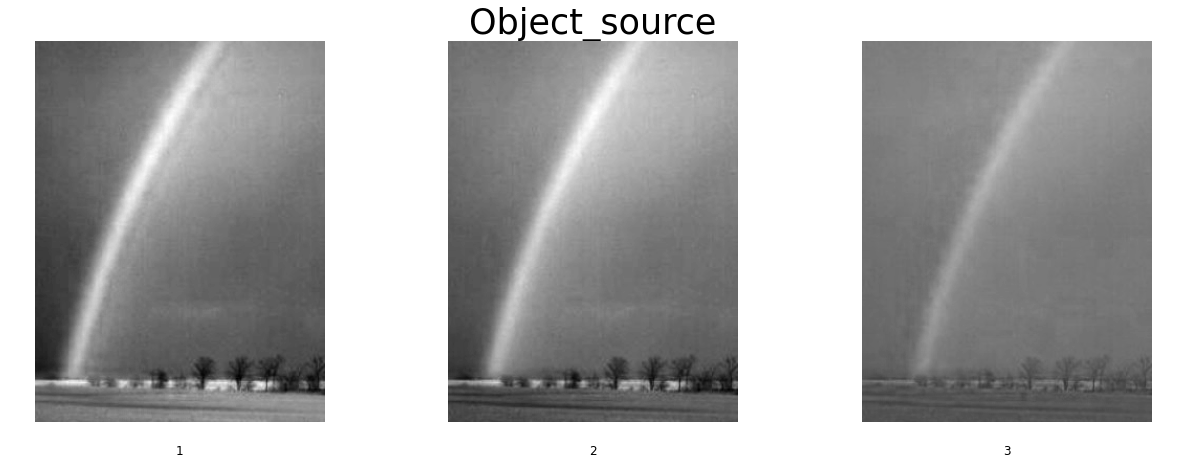

In [8]:
fig = plt.figure(figsize=(21, 7))
# plt.imshow(a.astype(np.uint8), cmap="gray")
plt.title("Object_source", fontsize = 35)
plt.axis('off')

fig.add_subplot(1, 3, 1)
plt.imshow(object_source1, cmap="gray")
plt.axis('off')
plt.title("1", y = -0.1)

fig.add_subplot(1, 3, 2)
plt.imshow(object_source2, cmap="gray")
# The paper lists that color and detail layers are multiplied by a factor of four to enhance the image
plt.axis('off')
plt.title("2", y = -0.1)

fig.add_subplot(1, 3, 3)
plt.imshow(object_source3, cmap="gray", vmin = 0 , vmax = 255)
plt.axis('off')
plt.title("3", y = -0.1)


Text(0.5, -0.1, '3')

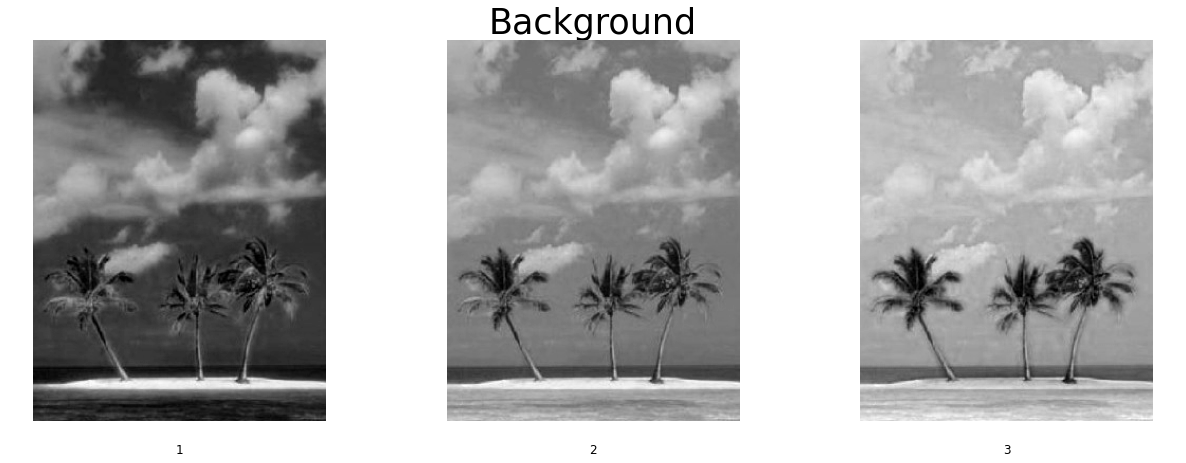

In [9]:
fig = plt.figure(figsize=(21, 7))
# plt.imshow(a.astype(np.uint8), cmap="gray")
plt.title("Background", fontsize = 35)
plt.axis('off')

fig.add_subplot(1, 3, 1)
plt.imshow(background1, cmap="gray")
plt.axis('off')
plt.title("1", y = -0.1)

fig.add_subplot(1, 3, 2)
plt.imshow(background2, cmap="gray")
# The paper lists that color and detail layers are multiplied by a factor of four to enhance the image
plt.axis('off')
plt.title("2", y = -0.1)

fig.add_subplot(1, 3, 3)
plt.imshow(background3, cmap="gray", vmin = 0 , vmax = 255)
plt.axis('off')
plt.title("3", y = -0.1)


Text(0.5, -0.1, '3')

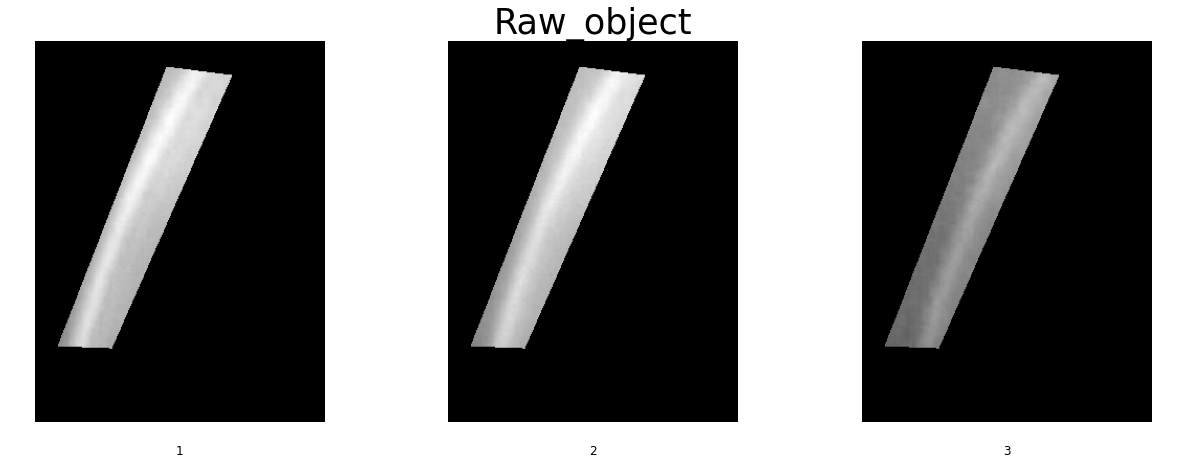

In [10]:
fig = plt.figure(figsize=(21, 7))
# plt.imshow(a.astype(np.uint8), cmap="gray")
plt.title("Raw_object", fontsize = 35)
plt.axis('off')

fig.add_subplot(1, 3, 1)
plt.imshow(raw_object1, cmap="gray")
plt.axis('off')
plt.title("1", y = -0.1)

fig.add_subplot(1, 3, 2)
plt.imshow(raw_object2, cmap="gray")
# The paper lists that color and detail layers are multiplied by a factor of four to enhance the image
plt.axis('off')
plt.title("2", y = -0.1)

fig.add_subplot(1, 3, 3)
plt.imshow(raw_object3, cmap="gray", vmin = 0 , vmax = 255)
plt.axis('off')
plt.title("3", y = -0.1)

In [11]:
background_x = variables['background_x']
background_y = variables['background_y']

In [16]:
def boundary_test(matrix, i, j):
    m, n = matrix.shape
    judgement = np.empty((m, n))
    judgement.fill(-1)
    
    i1 = (i - 1) >= 0
    i2 = (i + 1) < m
    j1 = (j - 1) >= 0
    j2 = (j + 1) < n
    t = np.logical_and(i1, i2)
    t = np.logical_and(t, j1)
    t = np.logical_and(t, j2)
    judgement[t] = 2
    
    t_1 = np.logical_and(t, (matrix != 0))
    i, j = np.where(t_1)
    
    s = (matrix[i + 1, j] == 0)
    i_p = i[s]
    j_p = j[s]
    judgement[i_p, j_p] = 1
    
    s = (matrix[i - 1, j] == 0)
    i_p = i[s]
    j_p = j[s]
    judgement[i_p, j_p] = 1
    
    s = (matrix[i, j + 1] == 0)
    i_p = i[s]
    j_p = j[s]
    judgement[i_p, j_p] = 1
    
    s = (matrix[i, j - 1] == 0)
    i_p = i[s]
    j_p = j[s]
    judgement[i_p, j_p] = 1
    
    t_2 = np.logical_and(t, (matrix == 0))
    judgement[t_2] = 0
    
    
    return judgement

In [82]:
def PoissonEditing(raw_object, background, background_x, background_y, no_of_iterations = 5000):
    m, n = np.where(raw_object > 0)
    m_min, m_max = m.min(), m.max()
    n_min, n_max = n.min(), n.max()
    object_m = np.zeros((m_max - m_min + 3, n_max - n_min + 3))
    j, i = np.meshgrid(np.arange(n_min, n_max), np.arange(m_min, m_max))
    object_m[i - m_min + 2, j - n_min + 2] = raw_object[i, j]
    
    object_mask = object_m.copy()
    object_mask[object_mask > 0] = 1
    
    m, n = object_m.shape
    boundary_filter = np.zeros((m, n))
    j, i = np.meshgrid(np.arange(n), np.arange(m))
    b_t = boundary_test(object_m, i, j)
    boundary_filter[b_t == 1] = 1
    
    boundary = np.zeros((m, n))
    i, j = np.where(b_t == 1)
    i_m = np.around(background_y - m / 2 + i).astype('int')
    j_m = np.around(background_x - n / 2 + j).astype('int')
    boundary[i, j] = background[i_m, j_m]

    background_region = np.zeros((m, n))
    indices_reqd = np.logical_or(b_t == 1, b_t == 2)
    i, j = np.where(indices_reqd)
    i_m = np.around(background_y - m / 2 + i).astype('int')
    j_m = np.around(background_x - n / 2 + j).astype('int')
    background_region[i, j] = background[i_m, j_m]
    gradience_filter = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    
    from scipy.signal import convolve2d
    background_gradience = convolve2d(background_region, gradience_filter, mode='same')
    background_gradience = background_gradience * object_mask
    background_gradience = background_gradience * (1 - boundary_filter)
    
    object_gradience = convolve2d(object_m, gradience_filter, mode = 'same')
    object_gradience = object_gradience * object_mask
    object_gradience = object_gradience * (1 - boundary_filter)
    
    mix_gradience = np.empty((m, n))
    greater = np.abs(object_gradience) >= np.abs(background_gradience)
    i, j = np.where(greater)
    mix_gradience[i, j] = object_gradience[i, j]
    lesser = np.logical_not(greater)
    i, j = np.where(lesser)
    mix_gradience[i, j] = background_gradience[i, j]
    
    mix_gradience = mix_gradience * (1 - boundary_filter)
    mix_gradience = mix_gradience + boundary
    
    gradience_filter2 = np.array([[0, 1 ,0], [1, 0, 1], [0, 1, 0]])
    object_old = boundary.copy()
    object_new = object_old.copy()
    
    region_without_boundary = object_mask - boundary_filter
    mix_gradience = mix_gradience * region_without_boundary
    
    for _ in range(no_of_iterations):
        Rx = convolve2d(object_old, gradience_filter2,mode='same')
        i, j = np.where(region_without_boundary > 0)
        object_new[i, j] = 0.25 * (mix_gradience[i, j] + Rx[i, j])
        object_old = object_new.copy()

    object_new = object_old.copy()
    object_new = object_new * object_mask
    
    i, j = np.where(object_new != 0)
    i_p = np.round(background_y - m / 2 + i).astype('int')
    j_p = np.round(background_x - n / 2 + j).astype('int')
    background_copy = background.copy()
    object_new = np.clip(object_new, 0, 255).astype(np.uint8)
    background_copy[i_p, j_p] = object_new[i, j]
    new_background = background_copy
    return new_background

In [87]:
m, n = background1.shape
h = np.empty((m, n, 3)).astype(np.uint8)
h[:, :, 0] = PoissonEditing(raw_object1, background1, background_x[0, 0], background_y[0,0])
h[:, :, 1] = PoissonEditing(raw_object2, background2, background_x[0, 0], background_y[0,0])
h[:, :, 2] = PoissonEditing(raw_object3, background3, background_x[0, 0], background_y[0,0])

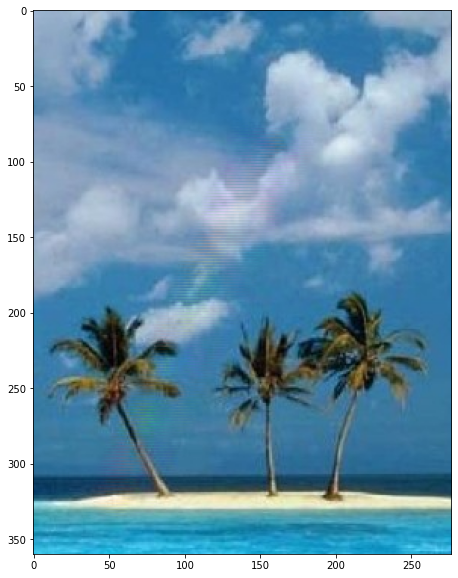

In [88]:
plt.figure(figsize = (10, 10))

plt.imshow(h)